# Models to Predict Merchant Revenue

This notebook contains various models we used to predict merchant revenue, such as Linear Regression, XGBoost, Random Forest Regression, and SARIMAX time series model.

<div class="alert alert-block alert-warning">
This notebook contains discontiued ideas. We did not end up using these models in our final ranking system.
</div>

In [1]:
# import constants and libraries
import sys
sys.path.append('../scripts/utils')
from constants import *

import pandas as pd
import numpy as np
import os

# spark libraries:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

# visualization tools:
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn models:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split

# ARIMA Model:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
import pmdarima as pm

# silence warning 
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/16 17:32:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/16 17:32:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/10/16 17:32:20 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/10/16 17:32:20 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


## Prepare our Data

First, we want to prepare our data and build appropriate dataframes for model training and testing, such as calculating aggregates and computing lags.

Code inspired by: https://www.kaggle.com/code/badl071/forecasting-future-sales-using-machine-learning#Forecasting-Future-Sales-Using-Machine-Learning

In [3]:
# read data
transactions = spark.read.parquet(f"{CURATED_DATA}transactions")

# filter for 28/02/2021 - 28/08/2022
start_date = "2021-02-28"
end_date = "2022-08-28"
transactions = transactions.filter((F.col("order_datetime") >= start_date) & (F.col("order_datetime") <= end_date))

# aggregate
daily_revenue = transactions.groupBy("merchant_abn", "order_datetime").agg(
    F.sum("dollar_value").alias("revenue")
)

# test merchant (random merchant for purpose of testing)
random_merchant = daily_revenue.where(F.col("merchant_abn") == 82065156333).orderBy(F.col("order_datetime"))

In [4]:
merchant_transactions = daily_revenue.groupBy("merchant_abn").agg(F.count("order_datetime").alias("num")).orderBy(F.col("num"))
everyday_transactions = merchant_transactions.where(F.col("num") == 547).count()
total_merchants = merchant_transactions.count()
print(f"{everyday_transactions/total_merchants*100:.2f}% of merchants have transactions everyday")
print(f"That is, only {everyday_transactions} merchants are consistent everyday")

14.10% of merchants have transactions everyday
That is, only 567 merchants are consistent everyday


### Trend Visualization on Merchant 82065156333

We randomly take a random merchant and use that merchant's data to develop our model

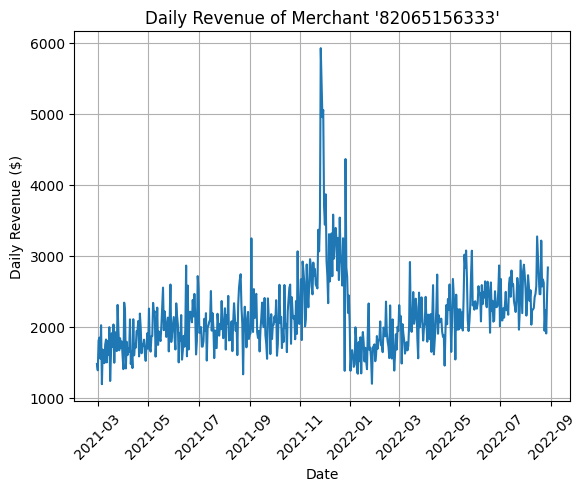

In [5]:
random_merchant_df = random_merchant.toPandas()
plt.plot(random_merchant_df["order_datetime"], random_merchant_df["revenue"])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Daily Revenue ($)")
plt.title("Daily Revenue of Merchant '82065156333'")
plt.grid(True)
plt.show()

## Preparation for Time Series Models:
We compute the difference in daily revenue and use it to obtain a stationary data for use in time series model such as SARIMAX.

In [6]:
# define functions

def get_diff(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Helper function to calculate the difference in revenue day by day.
    Arguments:
        - data: dataframe of revenue
    Output:
        - dataframe after differencing transformation
    '''
    
    data['rev_diff'] = data.revenue.diff()
    data = data.dropna()
    print(type(data))
    return data


def time_plot(df: pd.DataFrame, x_col: str, y_col: str, title: str) -> None:
    '''
    Helper function to plot trend of average monthly transactions revenue superimposed on daily transaction trend
    Arguments:
        - df: dataframe of revenue
        - x_col: column name for x axis
        - y_col: column name for y axis
        - title: title of the plot
    Output:
        None
    '''

    fig, ax = plt.subplots(figsize = (15,8))
    sns.lineplot(data = df, x = x_col, y = y_col, ax = ax, color = 'steelblue', label='Revenue')

    # get monthly average revenue, then plot as a line
    df["month_year"] = df['order_datetime'].dt.strftime('%Y-%m')
    s_mean = df.groupby(df.month_year)[y_col].mean().reset_index()
    s_mean["order_datetime"] = pd.to_datetime(s_mean['month_year'] + '-01')
    sns.lineplot(data = s_mean, x = s_mean.order_datetime, y = y_col, ax=ax, color='red', label='Mean Revenue')   
    
    ax.set(xlabel = "Date",
           ylabel = "Revenue",
           title = title)

    plt.show()

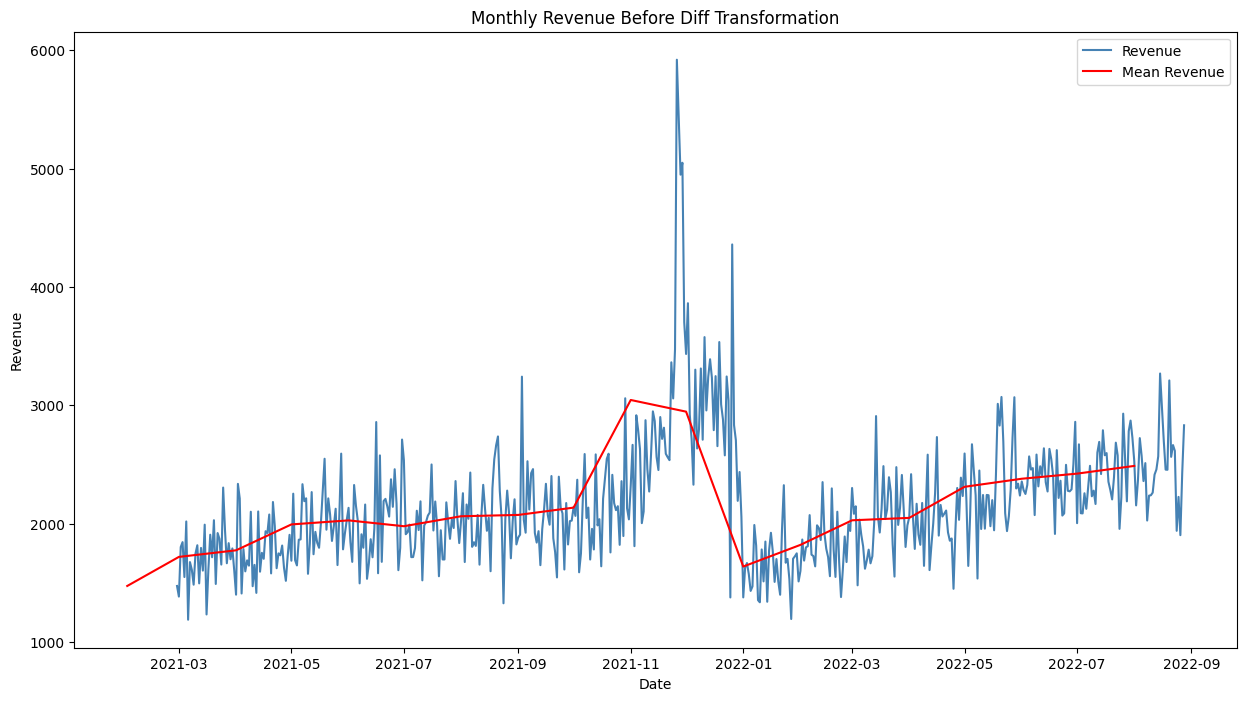

In [7]:
# visualization of monthly revenue before differencing
m_df = random_merchant_df[["order_datetime", "revenue"]]
m_df['order_datetime'] = pd.to_datetime(m_df['order_datetime'], format='%Y-%m-%d')
time_plot(m_df, x_col='order_datetime', y_col='revenue', title='Monthly Revenue Before Diff Transformation')

<class 'pandas.core.frame.DataFrame'>


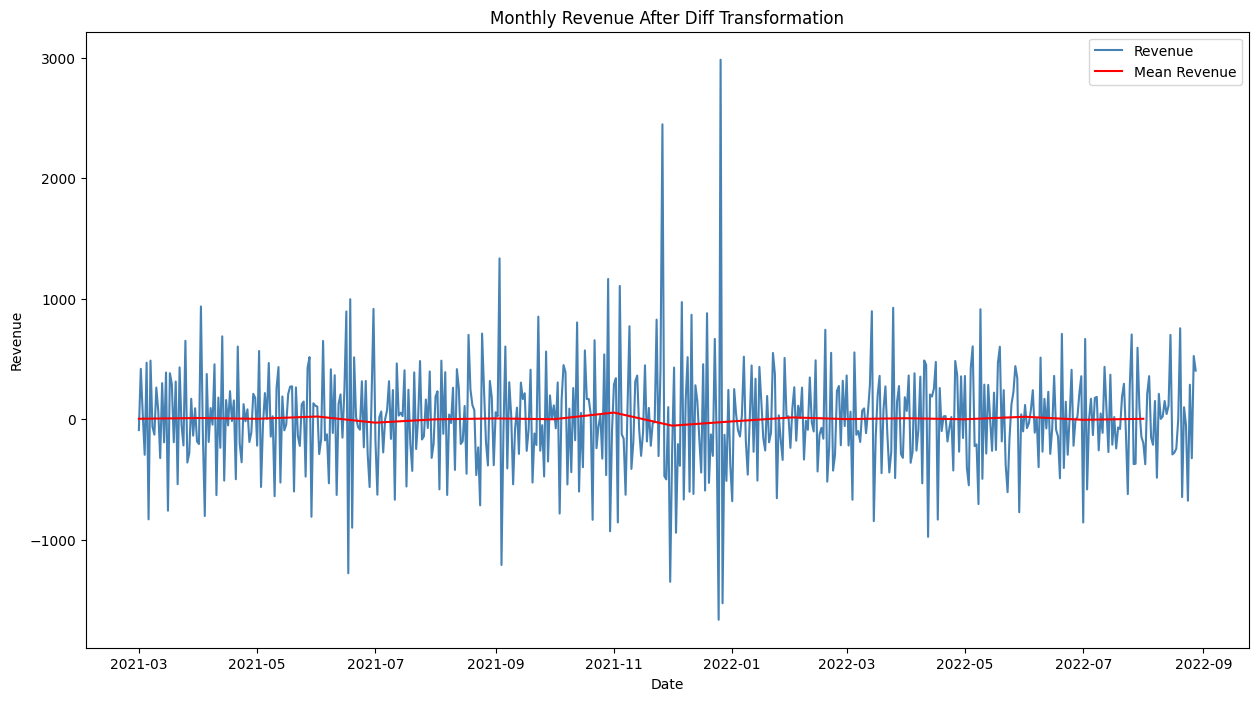

In [8]:
# get stationary dataframe
stationary_df = get_diff(m_df)

# visualization of monthly revenue after differencing
time_plot(stationary_df, 'order_datetime', 'rev_diff', 'Monthly Revenue After Diff Transformation')

In [9]:
def build_arima_data(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Generates a dataframe with a datetime index and a dependent revenue column for ARIMA modeling.
    Arguments:
        - data: dataframe to be processed
    Output:
        - the processed dataframe
    '''
    
    da_data = data.set_index('order_datetime').drop(['month_year', 'revenue'], axis=1)
    da_data.dropna(axis=0)
    return da_data

# last touches to obtain a dataframe ready for training
datatime_df = build_arima_data(stationary_df)

## Preparation For Regressive Models:

### Computing Lags
As we are dealing with a time series data, we compute the lags to be used as features in our model. We explored various lag values but ulimately chose lags = 14 days as we hope this might capture more than just weekly seasonality/pattern. Note that increasing the lags reduces the MAE for Linear Regression.

In [10]:
def built_supervised(data: pd.DataFrame, num_lags: int = 14) -> pd.DataFrame:
    '''
    Build a dataframe with 14 days of lags as features.
    Arguments:
        - data: dataframe of revenue to be processed
        - num_lags: number of lag days (defaults to 14 days)
    Output:
        - dataframe with lags as features
    '''

    supervised_df = data.copy()

    # create column for each lag
    for i in range(1, num_lags+1):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['rev_diff'].shift(i)

    # drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    return supervised_df

In [11]:
# create dataframe with 14 previous days as features
model_df = built_supervised(stationary_df)
model_df.head(5)

,order_datetime,revenue,month_year,rev_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
0,2021-03-15,1991.2579,2021-03,388.0194,-191.5772,299.6446,-322.1435,70.2431,262.9017,-127.5839,-63.1456,486.8930,-830.4327,469.5544,-294.8863,41.6268,418.5612,-89.7271
1,2021-03-16,1232.5530,2021-03,-758.7049,388.0194,-191.5772,299.6446,-322.1435,70.2431,262.9017,-127.5839,-63.1456,486.8930,-830.4327,469.5544,-294.8863,41.6268,418.5612
2,2021-03-17,1614.7056,2021-03,382.1526,-758.7049,388.0194,-191.5772,299.6446,-322.1435,70.2431,262.9017,-127.5839,-63.1456,486.8930,-830.4327,469.5544,-294.8863,41.6268
3,2021-03-18,1906.4329,2021-03,291.7273,382.1526,-758.7049,388.0194,-191.5772,299.6446,-322.1435,70.2431,262.9017,-127.5839,-63.1456,486.8930,-830.4327,469.5544,-294.8863
4,2021-03-19,1716.0183,2021-03,-190.4146,291.7273,382.1526,-758.7049,388.0194,-191.5772,299.6446,-322.1435,70.2431,262.9017,-127.5839,-63.1456,486.8930,-830.4327,469.5544


### Helper Functions for Model Training + Evaluation
Next, we define some helper functions for training regressive models and evaluating them.
  * train and test split data
    * 08/2022 for testing (28 days)
    * rest for train (511 days)
  * scaling data
  * reverse scaling
  * generate dataframe for predictions
  * evaluating models with RMSE, MAE and r2
  * plot model results
  * train different models
  

In [12]:
def train_test_split(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Helper function to split data to training and testing set.
    08/2022 data for testing (28 days) and the rest (02/2021 - 07/2022) for training (511 days).
    Arguments:
        - data: dataframe to be split
    Output:
        - the training set and test set 
    '''

    data = data.drop(['revenue','order_datetime', 'month_year'], axis=1)
    train , test = data[:-28].values, data[-28:].values
    return (train, test)

# split to train and test
train, test = train_test_split(model_df)
print(f"Shape of  Train: {train.shape}\nShape of  Test: {test.shape}")

Shape of  Train: (504, 15)
Shape of  Test: (28, 15)


In [13]:
def scale_data(train_set: pd.DataFrame, test_set: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, MinMaxScaler]:
    '''
    Helper function to scale data using MinMaxScaler and separates data into X_train, y_train, X_test, and y_test.
    Arguments:
        - train_set: training set dataframe
        - test_set: testing set dataframe
    Output:
        - flattened array of X_train, y_train, X_test, and y_test
        - the scaler object
    '''
    
    # apply Min Max Scaler:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set:
    train_set = train_set.reshape(train_set.shape[0],
                                  train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set:
    test_set = test_set.reshape(test_set.shape[0], 
                                test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel() # returns the array, flattened
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f"Shape of X Train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X Test: {X_test.shape}\nShape of y Test: {y_test.shape}")

Shape of X Train: (504, 14)
Shape of y Train: (504,)
Shape of X Test: (28, 14)
Shape of y Test: (28,)


In [14]:
def re_scaling(y_pred: np.ndarray, x_test: np.ndarray, scaler_obj: MinMaxScaler, lstm: bool = False) -> np.ndarray:
    '''
    Undoes scaling effect of prediction (for visualizing and comparing results)
    Arguments:
        - y_pred: model predictions
        - x_test: features from the test set used for predictions
        - scaler_obj: the scaler objects used for min-max scaling
        - lstm: indicate if the model run is the lstm. if True, additional transformation occurs (not used)
    Output:
        - the predictions after rescaling
    '''
    
    # reshape y_pred:
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

    # rebuild test set for inverse transform:
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], x_test[index]], axis=1) )

    # reshape pred_test_set:
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

    # inverse transform:
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted

In [15]:
def prediction_df(unscale_predictions: np.ndarray, origin_df: pd.DataFrame) -> pd.DataFrame:
    '''
    Generates a dataframe that shows the predicted revenue (for plotting results)
    Arguments:
        - unscale_predictions: the model predictions that do not have min-max or other scaling applied
        - origin_df: the original revenue dataframe
    Output:
        - dataframe containing predicted revenue
    '''

    # create dataframe that shows the predicted revenue
    result_list = []
    sales_dates = list(origin_df[-29:].order_datetime)
    act_sales = list(origin_df[-29:].revenue)

    for index in range(0, len(unscale_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscale_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index + 1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

In [16]:
model_scores = {}

def get_scores(unscale_df: pd.DataFrame, origin_df: pd.DataFrame, model_name: str) -> None:
    '''
    Prints the root mean squared error, mean absolute error, and r2 scores
    for each model. Saves all results in a model_scores dictionary for
    comparison.
    Arguments:
        - unscale_df: dataframe containing model predictions
        - origin_df: original dataframe containing ground truth
        - model_name: name of model we are evaluating
    Output:
        None
    '''

    rmse = np.sqrt(mean_squared_error(origin_df.revenue[-12:], 
                                      unscale_df.pred_value[-12:]))
    
    mae = mean_absolute_error(origin_df.revenue[-12:], 
                              unscale_df.pred_value[-12:])
    
    r2 = r2_score(origin_df.revenue[-12:], 
                  unscale_df.pred_value[-12:])
    
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

In [17]:
def plot_results(results: pd.DataFrame, origin_df: pd.DataFrame, model_name: str) -> None:
    '''
    Plot results of predictions in comparison to the ground truth.
    Arguments:
        - result: dataframe containing model predictions
        - origin_df: original dataframe containing ground truth
        - model_name: name of model we are evaluating
    Output:
        None
    '''

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=origin_df.order_datetime, y=origin_df.revenue, data=origin_df, ax=ax, 
                label='Original', color='blue')
    sns.lineplot(x=results.date, y=results.pred_value, data=results, ax=ax, 
                label='Predicted', color='red')
    ax.set(xlabel = "Date",
        ylabel = "Revenue",
        title = f"{model_name} Revenue Forecasting Prediction")

    ax.legend(loc='best')
    plt.savefig(f'{APPENDIX}/{model_name}_pred.jpg', dpi=300, bbox_inches="tight")
    plt.show()

In [18]:
def plot_zoomed_results(results: pd.DataFrame, origin_df: pd.DataFrame, model_name: str) -> None:
       '''
       Plot results of predictions in comparison to the ground truth, zoomed to period of predictions only.
       Arguments:
              - result: dataframe containing model predictions
              - origin_df: original dataframe containing ground truth
              - model_name: name of model we are evaluating
       Output:
              None
       '''

       fig, ax = plt.subplots(figsize=(15,5))
       
       # zoom in to period of predictions
       origin_df = origin_df[origin_df["order_datetime"] > '2022-07-31']
       results = results[results["date"] > '2022-07-31']
       
       sns.lineplot(x=origin_df.order_datetime, y=origin_df.revenue, data=origin_df, ax=ax, 
                 label='Original', color='blue')
       sns.lineplot(x=results.date, y=results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='red')
    
       ax.set(xlabel = "Date",
              ylabel = "Revenue",
              title = f"{model_name} Revenue Forecasting Prediction")
       
       ax.legend(loc='best')
       plt.savefig(f'{APPENDIX}/{model_name}_pred_zoomed.jpg', dpi=300, bbox_inches="tight")
       plt.show()

In [19]:
def regressive_model(train_data: np.ndarray, test_data: np.ndarray, model, model_name: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Runs regressive models in SKlearn framework. First calls scale_data
    to split into X and y and scale the data. Then fits and predicts. Finally,
    predictions are unscaled, scores are printed, and results are plotted and
    saved.
    Arguments: 
        - train_data: training set
        - test_data: test set
        - model: sklearn model object
        - model_name: name of the model
    Output:
        - predictions and ground truth dataframe
    '''

    # split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)

    # run sklearn models:
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test) # y_pred=predictions

    # undo scaling to compare predictions against original data:
    origin_df = m_df
    unscaled = re_scaling(predictions, X_test, scaler_object) # unscaled_predictions
    unscaled_df = prediction_df(unscaled, origin_df)

    # print scores and plot results:
    get_scores(unscaled_df, origin_df, model_name)
    plot_results(unscaled_df, origin_df, model_name)
    plot_zoomed_results(unscaled_df, origin_df, model_name)

    # return 
    return unscaled_df, origin_df

In [20]:
def compute_monthly_diff(pred: pd.DataFrame, actual: pd.DataFrame) -> tuple[int, int]:
    '''
    Compute the total monthly revenue of the predictions and the total monthly predictions of ground truth.
    Arguments:
        - pred: predictions dataframe
        - actual: ground truth dataframe
    Output:
        - total monthly revenue of predictions and ground truth
    '''
    
    actual = actual[-28:]
    monthly_revenue_pred = pred["pred_value"].sum()
    monthly_revenue_actual = actual["revenue"].sum()
    return (monthly_revenue_pred, monthly_revenue_actual)

## Modelling
We will employ the following models:
  * Linear Regression
  * Random Forest Regressor (RFR)
  * XGBoost 

In [21]:
# build folder under analysis to store results
folder = '../data/analysis/predictions/'
if not os.path.exists(folder):
    os.makedirs(folder)

### Linear Regression

RMSE: 345.6712625887515
MAE: 267.6161666666664
R2 Score: 0.013732646160175666


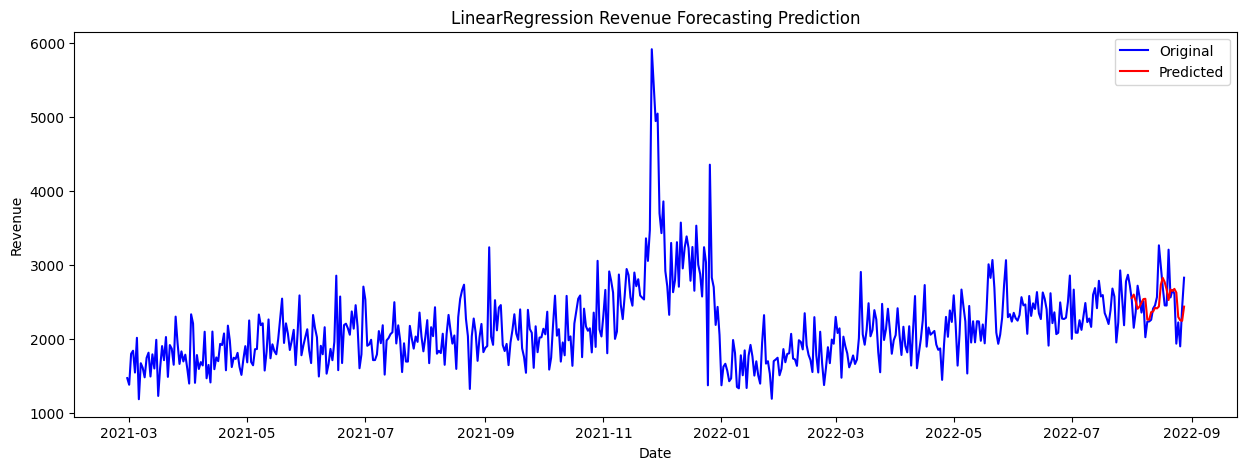

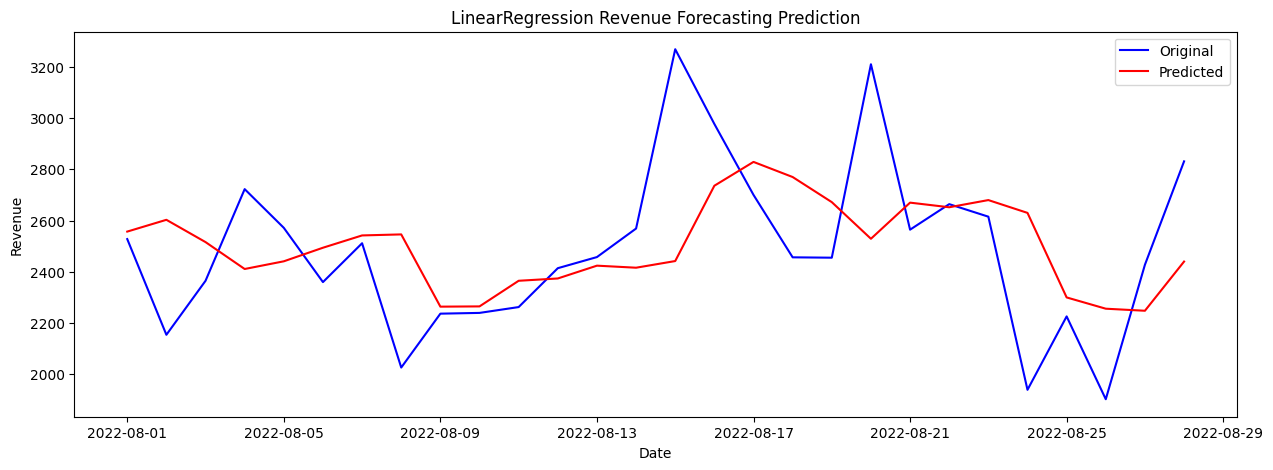

In [22]:
pred_lr, og_lr = regressive_model(train, test, LinearRegression(), 'LinearRegression')
monthly_pred_lr, monthly_actual_lr = compute_monthly_diff(pred_lr, og_lr)
pred_lr.to_pickle(f"{ANALYSIS_DATA}/predictions/revenue_predict_LR.pkl")

### Random Forest Regressor

RMSE: 434.84110204728984
MAE: 386.5244333333332
R2 Score: -0.5607354018601334


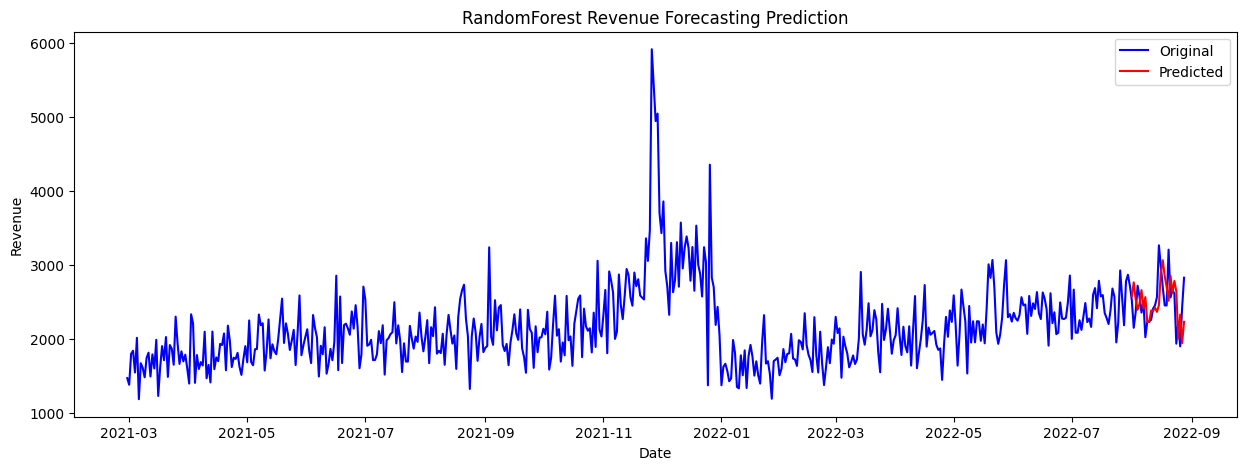

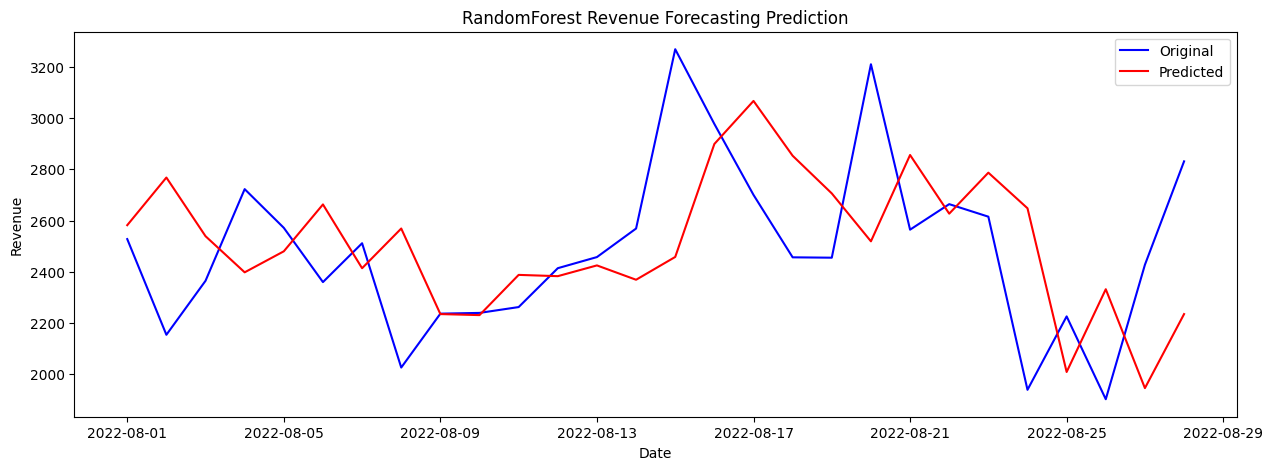

In [23]:
pred_rfr, og_rfr = regressive_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')
monthly_pred_rfr, monthly_actual_rfr = compute_monthly_diff(pred_rfr, og_rfr)
pred_rfr.to_pickle(f"{ANALYSIS_DATA}/predictions/revenue_predict_RFR.pkl")

### XGBoost

RMSE: 435.0592538337372
MAE: 358.44109999999984
R2 Score: -0.5623017791876856


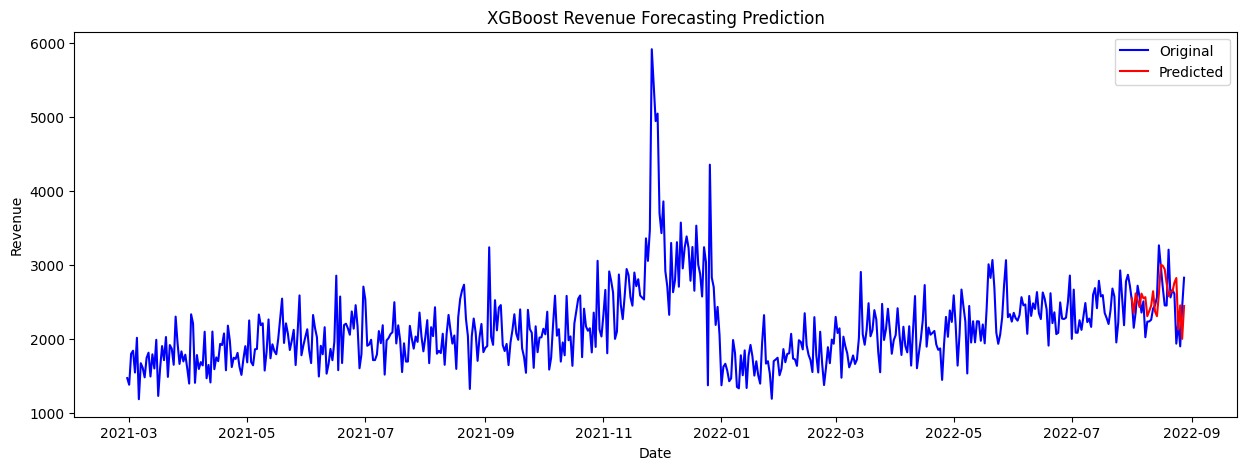

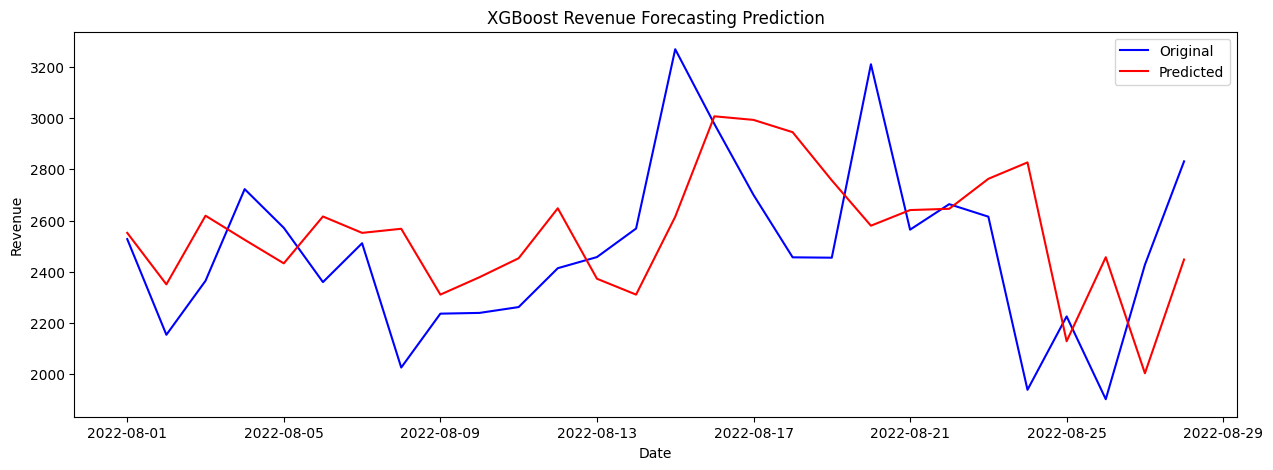

In [24]:
pred_xgb, og_xgb = regressive_model(train, test, XGBRegressor(n_estimators=100,max_depth=3, 
                                           learning_rate=0.2,objective='reg:squarederror'), 'XGBoost')
monthly_pred_xgb, monthly_actual_xgb = compute_monthly_diff(pred_xgb, og_xgb)
pred_xgb.to_pickle(f"{ANALYSIS_DATA}/predictions/revenue_predict_XGB.pkl")

## SARIMAX Model

Next, we also employ the SARIMAX model, a time series model.
  * Given that our data is daily and exhibits weekly patterns, we've appropriately set the seasonality parameter to 7, aligning with a weekly cycle (7 days).
  * To determine the remaining model parameters (p, d, q), we've implemented a stepwise algorithm driven by the Akaike Information Criterion (AIC).
  * Code Inspo:
      * https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/    
      * https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [25]:
def train_test_split(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Helper function to split data to training and testing set.
    08/2022 data for testing (28 days) and the rest (02/2021 - 07/2022) for training (511 days).
    Arguments:
        - data: dataframe to be split
    Output:
        - the training set and test set 
    '''
    
    data = data.drop(['merchant_abn'], axis=1)
    data.set_index("order_datetime", inplace=True)
    train , test = data[:-28], data[-28:]
    return (train, test)
    
# train, test split the data
train, test = train_test_split(random_merchant_df)

In [26]:
# find hyperparameters using AIC as selection criterion
smodel = pm.auto_arima(test['revenue'], start_p=1, start_q=1, max_p=3, max_q=3, m=7, start_P=0, seasonal=True,
    d=None, D=1, error_action='ignore', suppress_warnings=True, stepwise=True)
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   28
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 7)   Log Likelihood                -155.331
Date:                           Mon, 16 Oct 2023   AIC                            316.663
Time:                                   17:32:48   BIC                            319.796
Sample:                               08-01-2022   HQIC                           317.343
                                    - 08-28-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3650      0.217      1.681      0.093      -0.061       0.790
ar.S.L7       -0.5118      0.218     -2.346      0.019      -0.939      -0.084
sigma2      1.365e+05    4.5e+04      3.035      0.002    4.83e+04    2.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.99   Prob(JB):                         0.68
Heteroskedasticity (H):               1.51   Skew:                             0.46
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# fit the model
model = sm.tsa.statespace.SARIMAX(test['revenue'],order=(1, 0, 0),seasonal_order=(1,1,0,7))
results = model.fit()

# make predictions
prediction_sarimax = results.get_forecast(steps = 28).predicted_mean

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68023D+00    |proj g|=  2.02141D-01

At iterate    5    f=  5.57304D+00    |proj g|=  6.15713D-04

At iterate   10    f=  5.57299D+00    |proj g|=  4.63963D-03

At iterate   15    f=  5.56755D+00    |proj g|=  5.28595D-02

At iterate   20    f=  5.54761D+00    |proj g|=  8.81384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   3.434D-07   5.548D+00
  F =   5.5475474792807047     

CONVERG

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [28]:
# evaluate the rmse and mae
rmse = np.sqrt(mean_squared_error(prediction_sarimax, random_merchant_df.revenue[-28:]))
mae = mean_absolute_error(prediction_sarimax, random_merchant_df.revenue[-28:])
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 350.073
Test MAE: 290.606


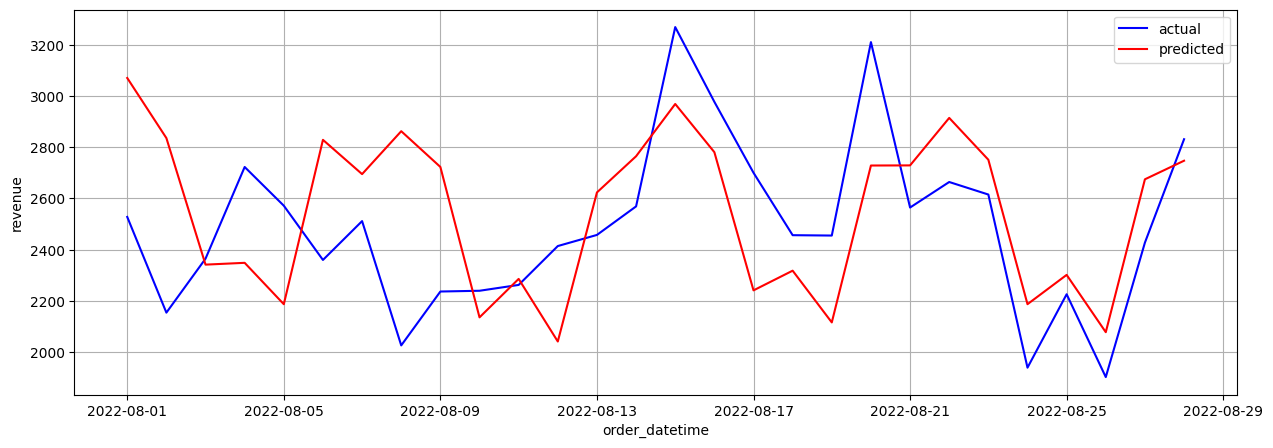

In [29]:
# plot results
random_merchant_df_cut = random_merchant_df[-28:]
random_merchant_df_cut["predictions"] = list(prediction_sarimax)
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x=random_merchant_df_cut.order_datetime, y=random_merchant_df_cut.revenue, data=random_merchant_df_cut, ax=ax, label='actual', color='blue')
sns.lineplot(x=random_merchant_df_cut.order_datetime, y=random_merchant_df_cut.predictions, data=random_merchant_df_cut, ax=ax, label='predicted', color='red')
plt.grid(True)
plt.savefig(f'{APPENDIX}/SARIMAX_pred_zoomed.jpg', bbox_inches="tight", dpi=300)
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.45937D+00    |proj g|=  5.47337D-03

At iterate    5    f=  7.45931D+00    |proj g|=  3.80839D-03

At iterate   10    f=  7.45621D+00    |proj g|=  5.57302D-02

At iterate   15    f=  7.44507D+00    |proj g|=  1.16401D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     20      1     0     0   2.158D-06   7.445D+00
  F =   7.4450669522973243     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


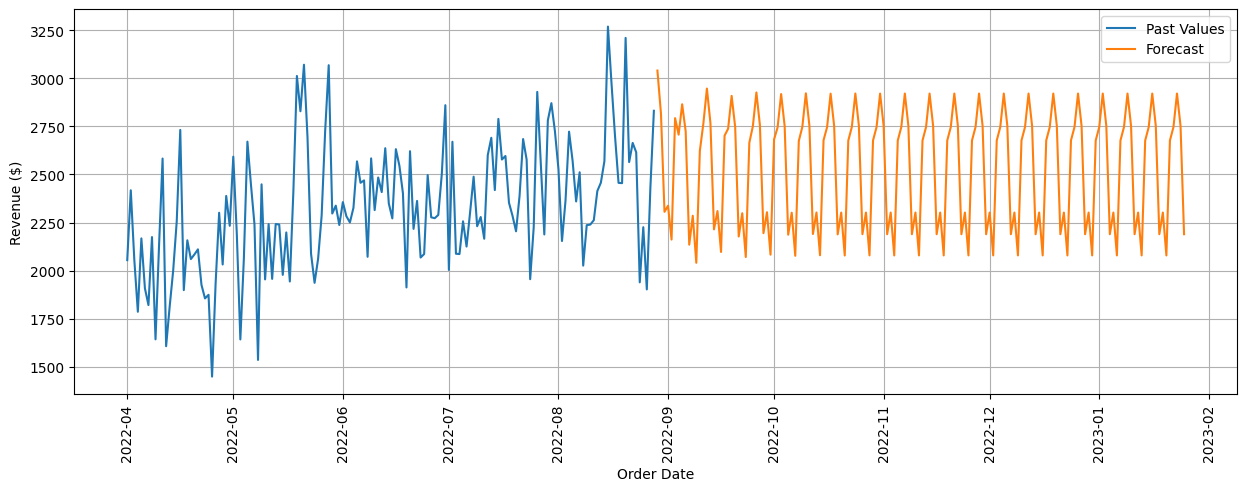

In [30]:
# retrain with whole dataset, then predict for next 365 days

model=sm.tsa.statespace.SARIMAX(random_merchant_df['revenue'],order=(1, 0, 0),seasonal_order=(1,1,0,7))
results=model.fit()
pred = results.get_forecast(steps=365).predicted_mean
test_df = random_merchant_df.set_index('order_datetime')
forecast_df = pd.DataFrame(data = pred.values, index=pd.date_range(start='2022-08-29',end='2023-08-28'))

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(test_df['revenue'].tail(150), label = "Past Values")
plt.plot(forecast_df.head(150), label = "Forecast")
plt.xlabel('Order Date')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.savefig(f"{APPENDIX}/predictions_sarimax.jpg", bbox_inches="tight", dpi=300)
plt.show()

## Comparing Monthly Revenue

In [31]:
print(f" Actual Monthly Revenue: ${monthly_actual_lr:11.2f}")
print(f"Monthly Revenue            ||   Predicted ($)   ||   Difference  ")
print("-------------------------------------------------------------")
print(f"Linear Regression:         ||{monthly_pred_lr:^19}||{(monthly_pred_lr-monthly_actual_lr):11.2f} ")
print(f"Random Forest Regression:  ||{monthly_pred_rfr:^19}||{(monthly_pred_rfr-monthly_actual_rfr):11.2f} ")
print(f"XGBoost:                   ||{monthly_pred_xgb:^19}||{(monthly_pred_xgb-monthly_actual_xgb):11.2f} ")
print(f"SARIMAX:                   ||{prediction_sarimax.sum():^19.2f}||{(prediction_sarimax.sum()-monthly_actual_rfr):11.2f} ")

 Actual Monthly Revenue: $   69656.67
Monthly Revenue            ||   Predicted ($)   ||   Difference  
-------------------------------------------------------------
Linear Regression:         ||       70072       ||     415.33 
Random Forest Regression:  ||       70386       ||     729.33 
XGBoost:                   ||       71503       ||    1846.33 
SARIMAX:                   ||     71278.98      ||    1622.32 
